# Na analysis (runs 3708, 3723, 3732, 3740, 3752 and 3755)

# Notebook configuration

In [1]:
outputfolder   = "plots/"
save_plots     = False
inputfilenames = "/Users/Gonzalo/github/NEXTdata/Na22/dst_37*.root.h5"

In [2]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Tue Apr 25 00:13:38 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 10, 8
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [66]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange, **kwargs)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
#    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), *args, weights=z_), plt.colorbar()

def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<100] = eref*1e8
        return eref/ e
    return xycorr

save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [5]:
ifiles = glob.glob(os.path.expandvars(inputfilenames))[1:]
names  = [ifile.split("_")[1].split(".")[0] for ifile in ifiles]
for name, ifile in zip(names, ifiles):
    print("ifile:", name, ifile)

ifile: 3723 /Users/Gonzalo/github/NEXTdata/Na22/dst_3723.root.h5
ifile: 3732 /Users/Gonzalo/github/NEXTdata/Na22/dst_3732.root.h5
ifile: 3740 /Users/Gonzalo/github/NEXTdata/Na22/dst_3740.root.h5
ifile: 3752 /Users/Gonzalo/github/NEXTdata/Na22/dst_3752.root.h5
ifile: 3755 /Users/Gonzalo/github/NEXTdata/Na22/dst_3755.root.h5


# Read data

In [6]:
dsts = [dstf.load_dst(ifile, "DST", "Events") for ifile in ifiles]
dsts[0].head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.492610e+09,0,2,175.0,22.244972,122.220965,200125.0,6.702875,1491.312134,...,357062.5,3,156.9375,156.9375,91.847051,7.581373,92.159416,0.082357,4.662771,4.391581
1,2,1.492610e+09,1,2,175.0,22.244972,122.220965,200125.0,24.197906,10286.971680,...,370587.5,29,170.4625,170.4625,88.404263,-8.109504,88.775434,-0.091476,10.082164,11.928488
2,5,1.492610e+09,0,2,175.0,19.151436,102.348111,200100.0,10.041250,14120.951172,...,249612.5,22,49.5125,49.5125,6.015279,134.187176,134.321933,1.525999,9.214987,9.126814
3,5,1.492610e+09,1,2,175.0,19.151436,102.348111,200100.0,8.969719,7283.956055,...,326412.5,14,126.3125,126.3125,-103.813277,122.840816,160.832405,2.272441,9.803254,7.278280
4,6,1.492610e+09,0,1,175.0,30.603943,148.309264,200100.0,17.692563,8046.501465,...,374162.5,34,174.0625,174.0625,-187.816854,4.415592,187.868753,3.118087,14.031739,10.930084


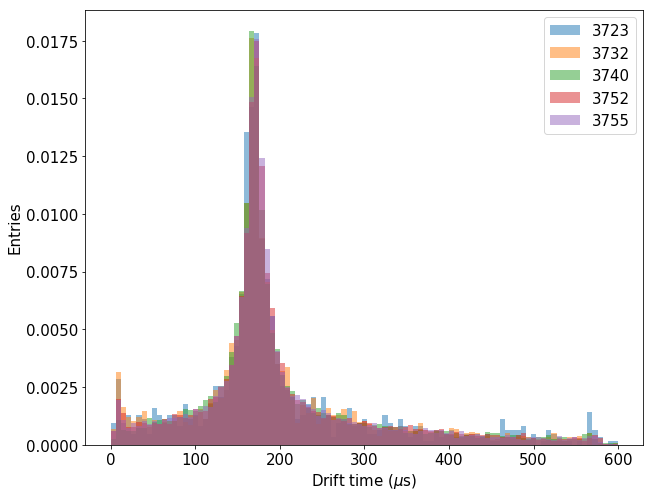

In [7]:
bins = np.linspace(0, 600, 100)
for name, dst in zip(names, dsts):
    plt.hist(dst.Z, bins, alpha=0.5, normed=True, label=name)
plt.legend()
labels("Drift time ($\mu$s)", "Entries")

# Raw spectrum

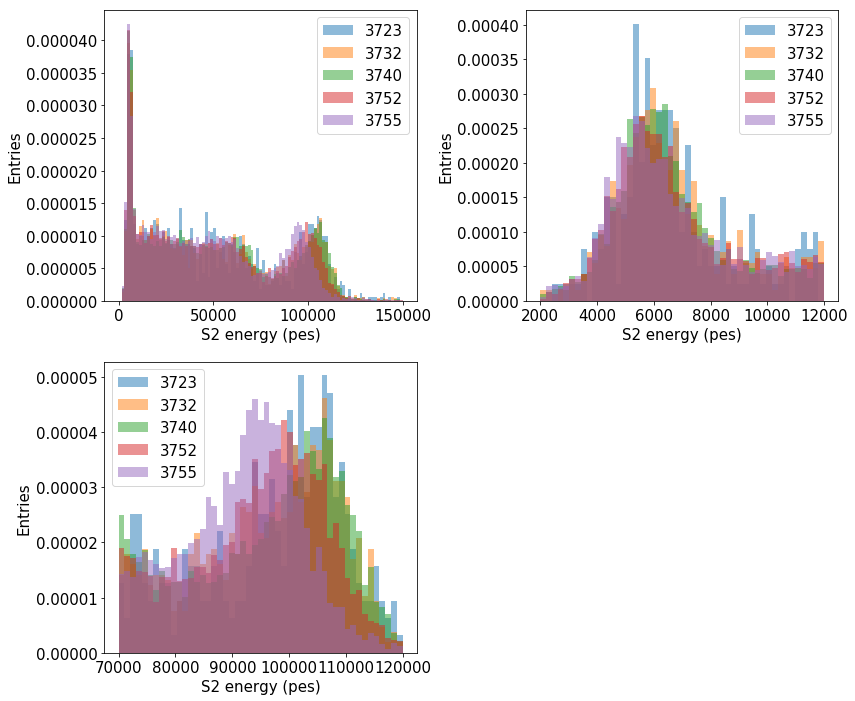

In [8]:
allbins = np.linspace(   0, 15e4, 100)
pebins  = np.linspace(70e3, 12e4,  50)
xrbins  = np.linspace( 2e3, 12e3,  50)

plt.figure().set_size_inches(12, 10)
for name, dst in zip(names, dsts):
    plt.subplot(2,2,1)
    plt.hist(dst.S2e, allbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,2)
    plt.hist(dst.S2e,  xrbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,3)
    plt.hist(dst.S2e,  pebins, alpha=0.5, normed=True, label=name)

for i in range(1,4):
    plt.subplot(2,2,i)
    labels("S2 energy (pes)", "Entries")
    plt.legend()

plt.tight_layout()

7.65289948057
14.8725496571
3.7369641954
0.517940568305
1.8295752297


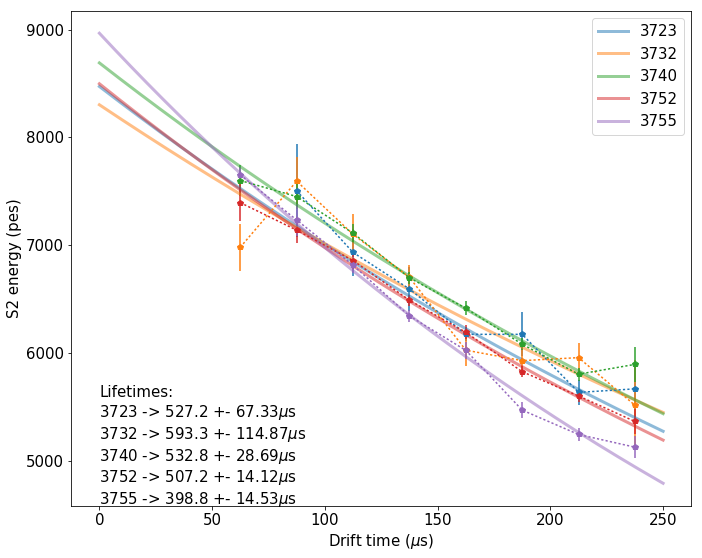

In [46]:
lts    = []
ltes   = []
zcorrs = []
for name, dst in zip(names, dsts):
    fid = dst[dst.R < 100]
    x, y, ye = fitf.profileX(fid.Z, fid.S2e, 8, xrange=(50, 250), yrange=(2e3, 8500))
    ye[ye==0] = 5*np.sqrt(y[ye==0])
    color   = plt.errorbar(x, y, ye, 0, "p:")[0].get_color()
    f = fitf.fit(fitf.expo, x, y, (7e3, -4e2), sigma=ye)
    print(f.chi2)
    x = np.linspace(0, 250, 250)
    plt.plot(x, f.fn(x), "-", color=color, alpha=0.5, label=name, linewidth=3)
    lts.append(-f.values[-1])
    ltes.append(f.errors[-1])
    zfun = f.fn
    zcorrs.append(lambda z: zfun(50)/zfun(z))
    
plt.text(0, plt.ylim()[0], "\n".join(["Lifetimes:"]+["{} -> {:.1f} +- {:.2f}$\mu$s".format(run, lt, lte) for run, lt, lte in zip(names, lts, ltes)]))

labels("Drift time ($\mu$s)", "S2 energy (pes)")
plt.legend()
plt.tight_layout()

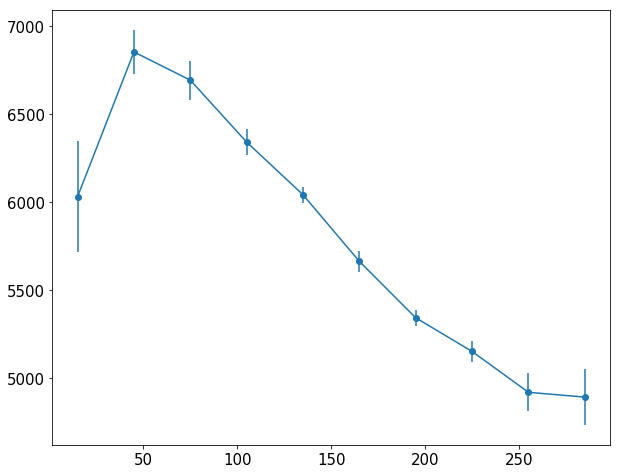

In [44]:
xr = dsts[-2][coref.in_range(dsts[-2].S2e, 2e3, 8500)]
#hist2d(xr.Z, xr.S2e, 15, ((0, 300), (2e3, 9e3)))
x, y, ye = fitf.profileX(xr.Z, xr.S2e, 10, (0, 300))
plt.errorbar(x, y, ye, marker="o");

# Z corrected spectrum

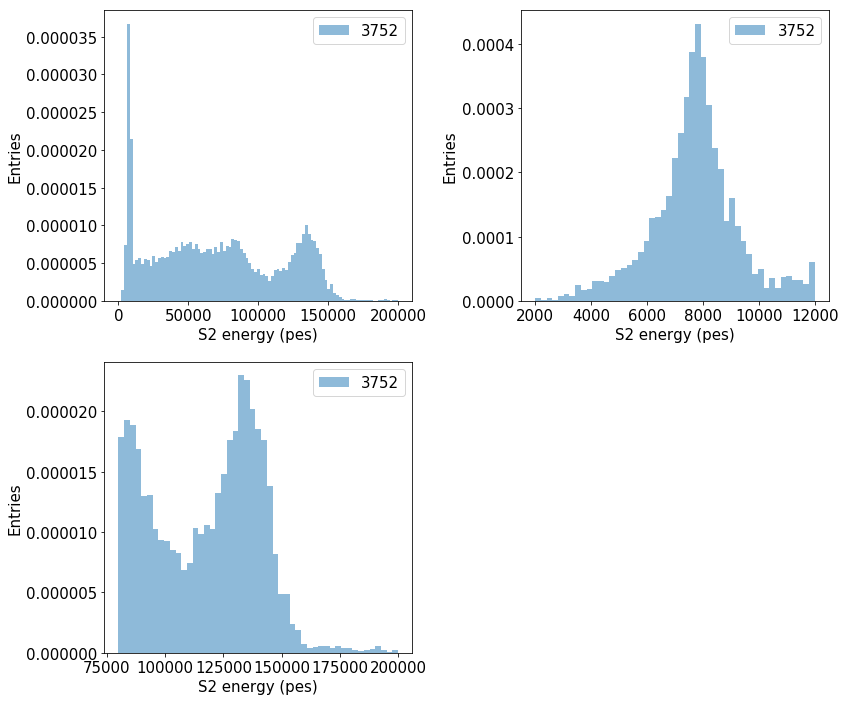

In [48]:
allbins = np.linspace(   0, 20e4, 100)
pebins  = np.linspace(80e3, 20e4,  50)
xrbins  = np.linspace( 2e3, 12e3,  50)

plt.figure().set_size_inches(12, 10)
for name, dst, zcorr in zip(names, dsts, zcorrs):
    if not name == "3752": continue
    plt.subplot(2,2,1)
    plt.hist(dst.S2e * zcorr(dst.Z.values), allbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,2)
    plt.hist(dst.S2e * zcorr(dst.Z.values),  xrbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,3)
    y, x, _ = \
    plt.hist(dst.S2e * zcorr(dst.Z.values),  pebins, alpha=0.5, normed=True, label=name)

for i in range(1,4):
    plt.subplot(2,2,i)
    labels("S2 energy (pes)", "Entries")
    plt.legend()

plt.tight_layout()

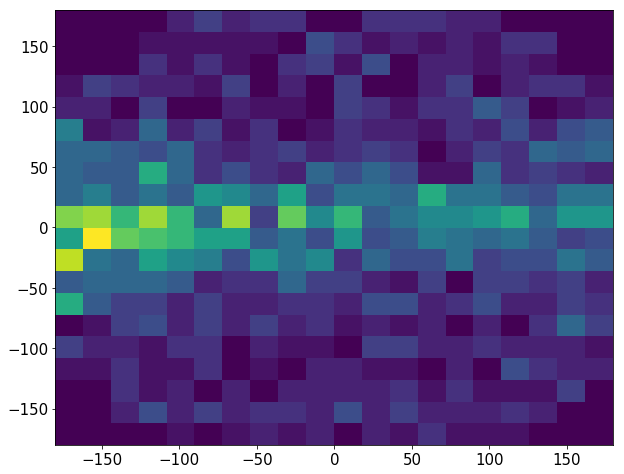

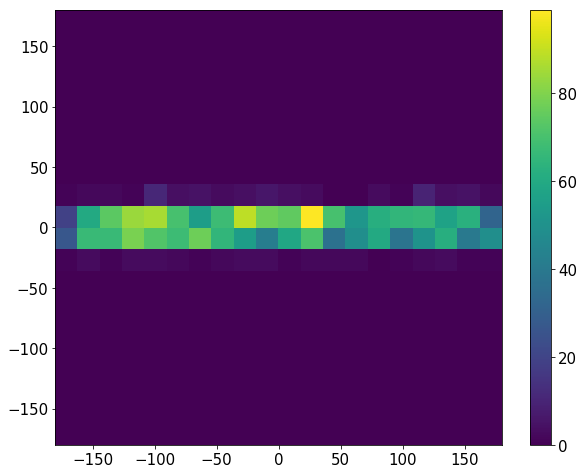

In [55]:
xr = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 2e3, 8500)]
hist2d(xr.X, xr.Y, 20, ((-180, 180), (-180, 180)));
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 120e3, 150e3) & coref.in_range(dsts[-2].Y, -20, 20)]
hist2d(pe.X, pe.Y, 20, ((-180, 180), (-180, 180)));
plt.colorbar()
#x, y, ye = fitf.profileX(xr.Z, xr.S2e, 10, (0, 300))
#plt.errorbar(x, y, ye, marker="o");

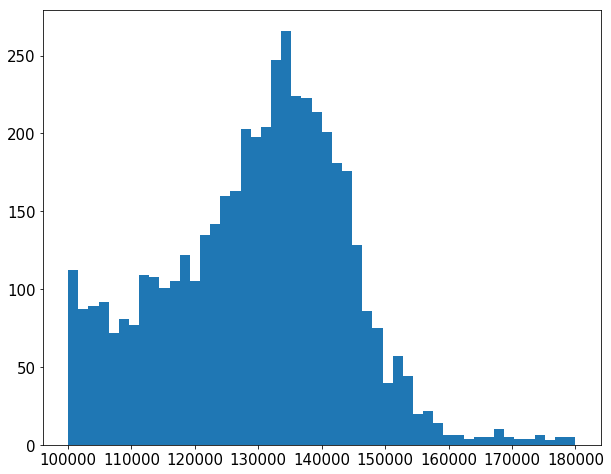

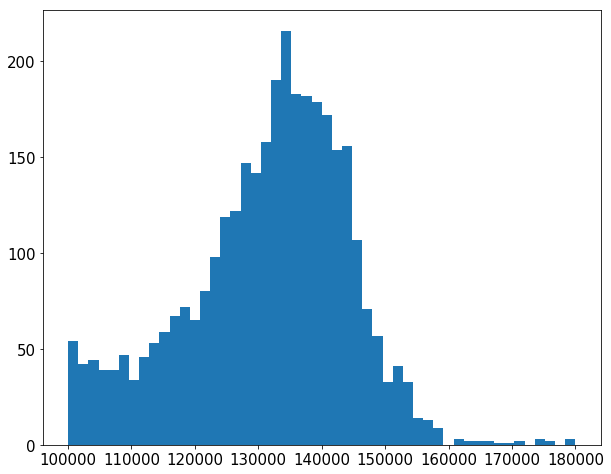

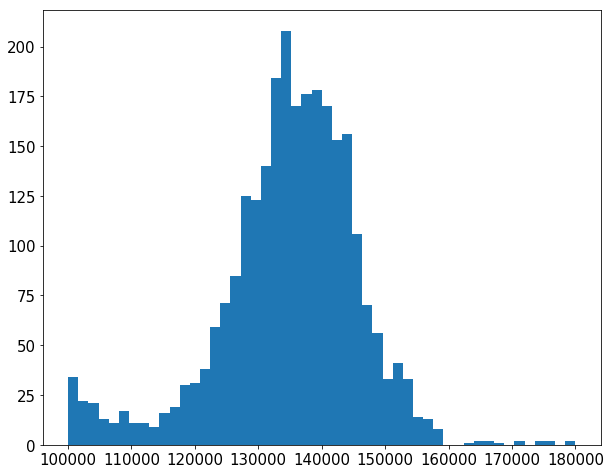

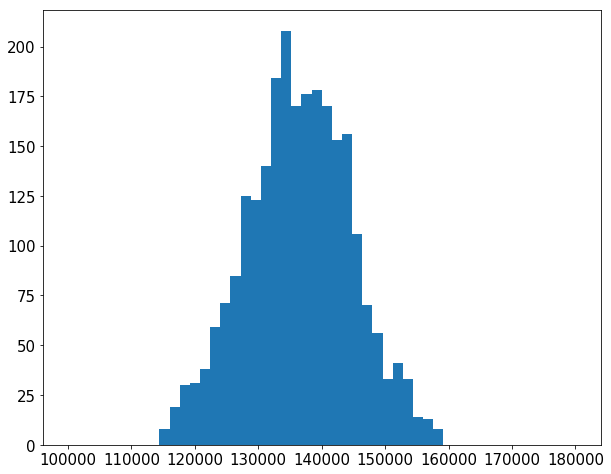

In [64]:
hist(dsts[-2].S2e * zcorr(dsts[-2].Z), 50, (100e3, 180e3))
pe = dsts[-2][coref.in_range(dsts[-2].Y, -20, 20)]
hist(pe.S2e* zcorr(pe.Z), 50, (100e3, 180e3));
pe = dsts[-2][coref.in_range(dsts[-2].Y, -20, 20) & coref.in_range(dsts[-2].X, -150, 150)]
hist(pe.S2e* zcorr(pe.Z), 50, (100e3, 180e3));
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 20) & coref.in_range(dsts[-2].X, -150, 150)]
hist(pe.S2e* zcorr(pe.Z), 50, (100e3, 180e3));
#plt.colorbar()


(array([-135., -105.,  -75.,  -45.,  -15.,   15.,   45.,   75.,  105.,  135.]), array([-10.,  10.]), array([[ 128698.54071442,  129928.24495714],
       [ 135473.60064158,  134826.27676816],
       [ 137873.22822894,  134079.54076661],
       [ 134543.62451949,  131198.44086646],
       [ 137046.1415746 ,  132455.17448312],
       [ 139652.04767314,  137618.4169349 ],
       [ 143788.41614063,  142308.69218931],
       [ 141480.9133289 ,  142177.27350651],
       [ 141000.00166927,  140144.98697493],
       [ 136043.33467325,  133862.77623065]]), array([[ 598.12904764,  567.87539042],
       [ 635.37103183,  549.89574043],
       [ 565.8868974 ,  695.05800311],
       [ 691.31297317,  544.11096085],
       [ 823.34294294,  502.08413141],
       [ 630.45107985,  615.9294923 ],
       [ 731.85527253,  535.22278704],
       [ 743.87548215,  606.57868749],
       [ 920.54027859,  604.20860637],
       [ 758.7105886 ,  649.60003568]]))


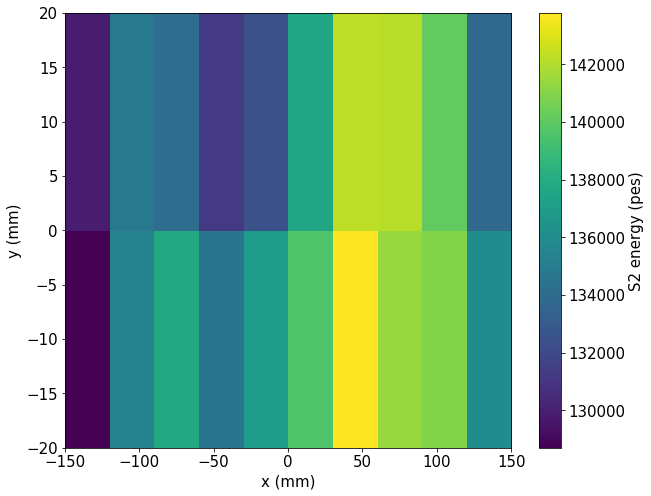

In [69]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 20) & coref.in_range(dsts[-2].X, -150, 150)]

pf, _, cb = profile_and_scatter(pe.X, pe.Y, pe.S2e * zcorr(pe.Z), (10, 2), (-150, 150), (-20, 20))
cb.set_label("S2 energy (pes)")
print(pf)
labels("x (mm)", "y (mm)")

(array([-135., -105.,  -75.,  -45.,  -15.,   15.,   45.,   75.,  105.,  135.]), array([-10.,  10.]), array([[ 125052.59428839,  125531.05627784],
       [ 130830.32256427,  130113.51027881],
       [ 132768.69953565,  129514.94355205],
       [ 129283.06370868,  126097.85069873],
       [ 130607.59265509,  126697.92895605],
       [ 134889.69656844,  132360.21286023],
       [ 140475.78837337,  137383.71216186],
       [ 135937.80772028,  136801.42313474],
       [ 135905.87852934,  135786.35796575],
       [ 131604.00954881,  128671.81672199]]), array([[  806.17727026,   949.11829002],
       [  973.48541149,   993.93486069],
       [ 1287.83796364,  1059.49339037],
       [ 1054.71940727,   862.05555199],
       [ 1417.00978409,   626.74476053],
       [ 1069.8723253 ,   980.98502278],
       [ 1147.18687866,   889.82450546],
       [ 1055.72865919,  1034.11146039],
       [ 1391.64118407,  1023.3027706 ],
       [ 1270.95493267,   913.27080665]]))


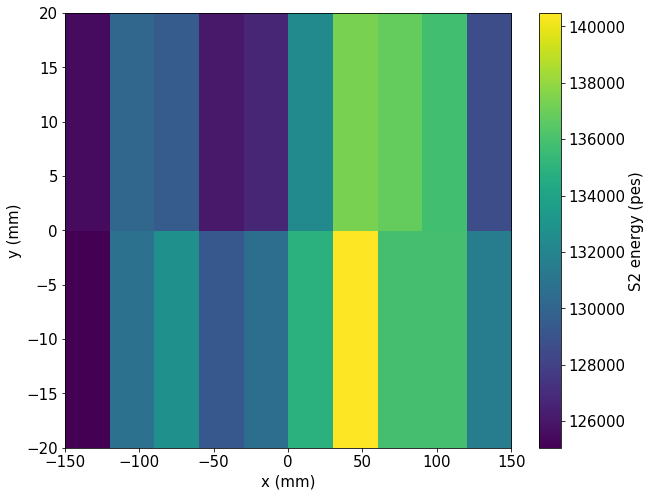

In [94]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 20) & coref.in_range(dsts[-2].X, -150, 150) & (dsts[-2].nS2==2)]

pf, _, cb = profile_and_scatter(pe.X, pe.Y, pe.S2e * zcorr(pe.Z), (10, 2), (-150, 150), (-20, 20))
cb.set_label("S2 energy (pes)")
print(pf)
labels("x (mm)", "y (mm)")

[ 228186.28321786  143436.41075506    3832.57224979] (6.2791203011850296, 2.8629800024781207)


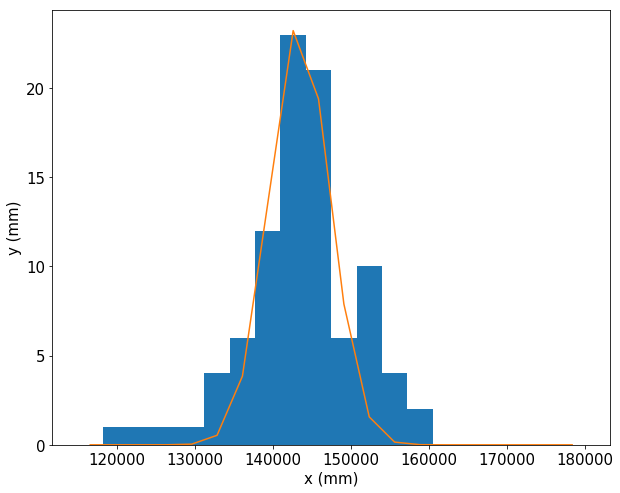

In [79]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 0) & coref.in_range(dsts[-2].X, 30, 60)]

y, x, _ = \
hist(pe.S2e * zcorr(pe.Z), 20, (115e3, 180e3)); x=  x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 145e3, 1e4), fit_range=(130e3, 150e3))
plt.plot(x, f.fn(x))
print(f.values, reso(f.values, 511))
labels("x (mm)", "y (mm)")

[  55866.87548812  138552.89799933    2129.12391981] (3.6112136835915858, 1.6465415639268546)


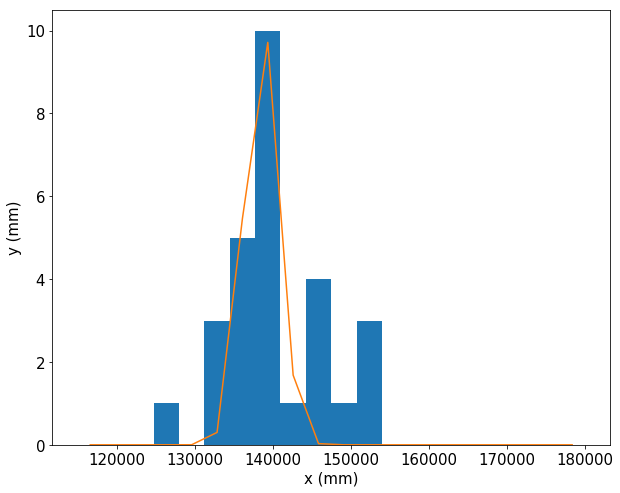

In [95]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 0) & coref.in_range(dsts[-2].X, 30, 60) & (dsts[-2].nS2==2)]

y, x, _ = \
hist(pe.S2e * zcorr(pe.Z), 20, (115e3, 180e3)); x=  x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 145e3, 1e4), fit_range=(130e3, 150e3))
plt.plot(x, f.fn(x))
print(f.values, reso(f.values, 511))
labels("x (mm)", "y (mm)")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 / (len(x) - len(vals)))


[ 230516.29965381  141956.49585233    2963.82339123] (4.9064221595250448, 2.2370949834779714)


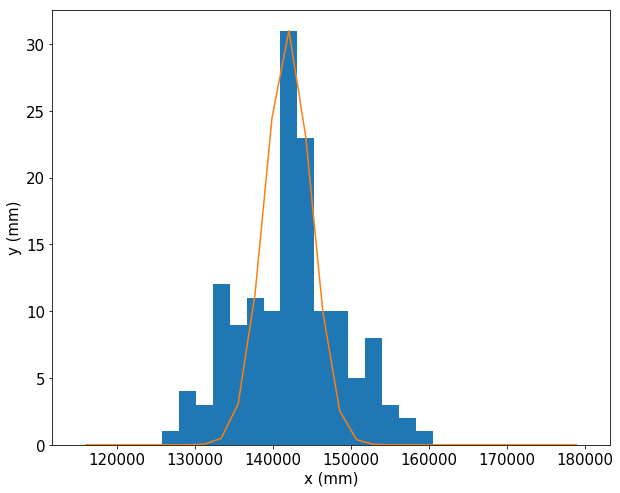

In [86]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, 0, 20) & coref.in_range(dsts[-2].X, 30, 60)]

y, x, _ = \
hist(pe.S2e * zcorr(pe.Z), 30, (115e3, 180e3)); x=  x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 145e3, 1e4), fit_range=(140e3, 148e3))
plt.plot(x, f.fn(x))
print(f.values, reso(f.values, 511))
labels("x (mm)", "y (mm)")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

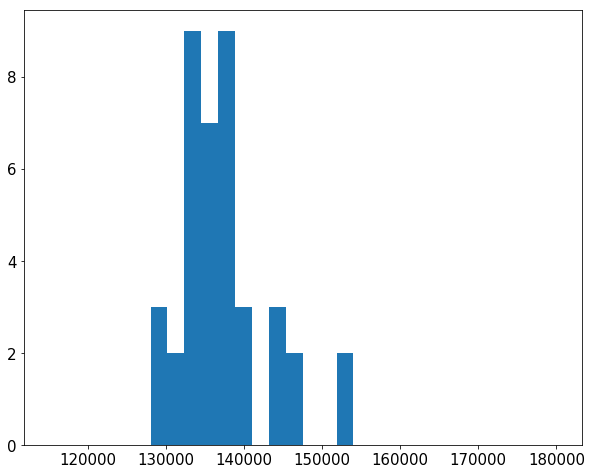

In [96]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, 0, 20) & coref.in_range(dsts[-2].X, 30, 60) & (dsts[-2].nS2==2)]

y, x, _ = \
hist(pe.S2e * zcorr(pe.Z), 30, (115e3, 180e3)); x=  x[:-1] + np.diff(x)*0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 145e3, 1e4), fit_range=(140e3, 148e3))
plt.plot(x, f.fn(x))
print(f.values, reso(f.values, 511))
labels("x (mm)", "y (mm)")

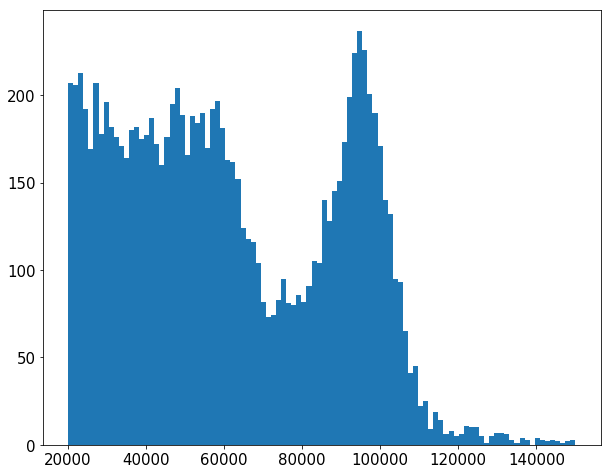

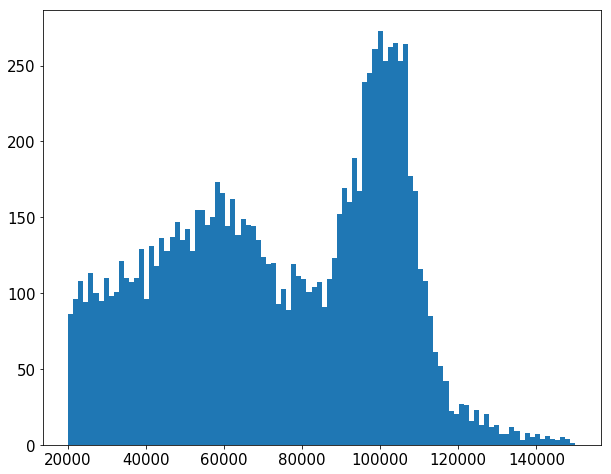

In [101]:
dst = dsts[-2]
dst = dst.groupby("event")

hist(dsts[-1].S2e, 100, (20e3, 150e3));
hist(dst.S2e.sum(), 100, (20e3, 150e3));

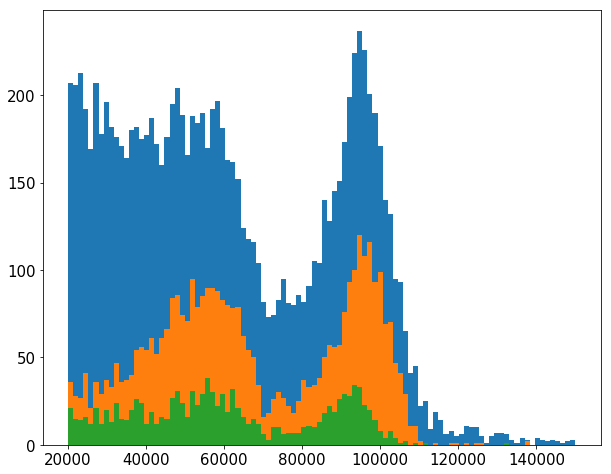

In [112]:
dst = dsts[-1]
hist(dst.S2e, 100, (20e3, 150e3));
dst = dst[coref.in_range(dst.Z, 160, 180)]
plt.hist(dst.S2e, 100, (20e3, 150e3));
dst = dst[dst.nS2==2]
plt.hist(dst.S2e, 100, (20e3, 150e3));

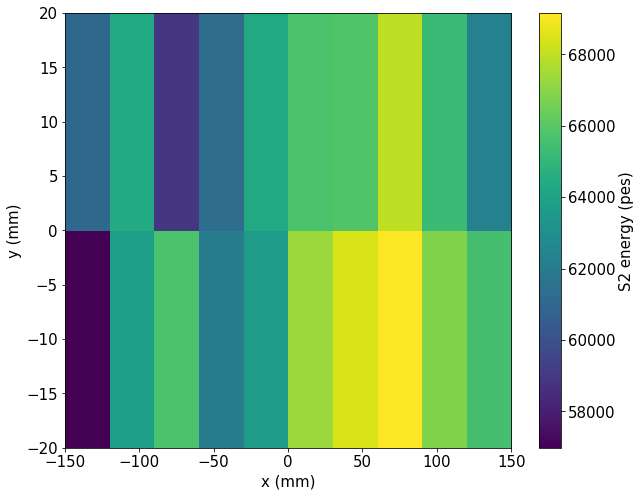

In [120]:
dst = dsts[-1]
dst = dst[dst.S2e < 120e3]
pf, _, cb = profile_and_scatter(dst.X, dst.Y, dst.S2e, (10, 2), (-150, 150), (-20, 20))
#pf, _, cb = profile_and_scatter(dst.X, dst.Y, dst.S2e, (10, 10), (-150, 150), (-50, 50))
cb.set_label("S2 energy (pes)")
#print(pf)
labels("x (mm)", "y (mm)")

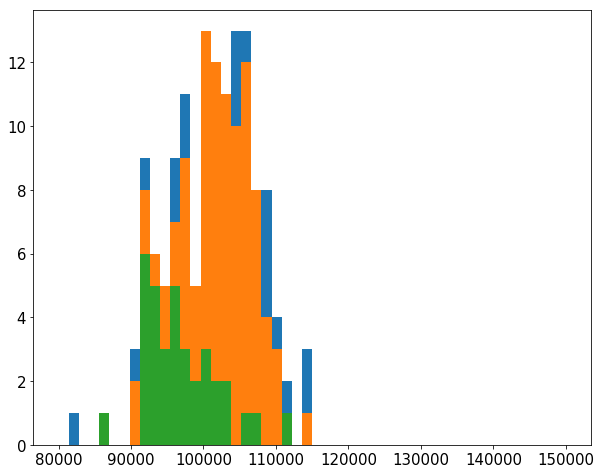

In [126]:
dst = dsts[-1]
dst = dst[dst.S2e < 120e3]
dst = dst[coref.in_range(dst.X,  50, 100)]
dst = dst[coref.in_range(dst.Y, -20,   0)]
hist(dst.S2e, 50, (80e3, 150e3));
dst = dst[coref.in_range(dst.Z, 150, 200)]
plt.hist(dst.S2e, 50, (80e3, 150e3));
dst = dst[dst.nS2==2]
plt.hist(dst.S2e, 50, (80e3, 150e3));

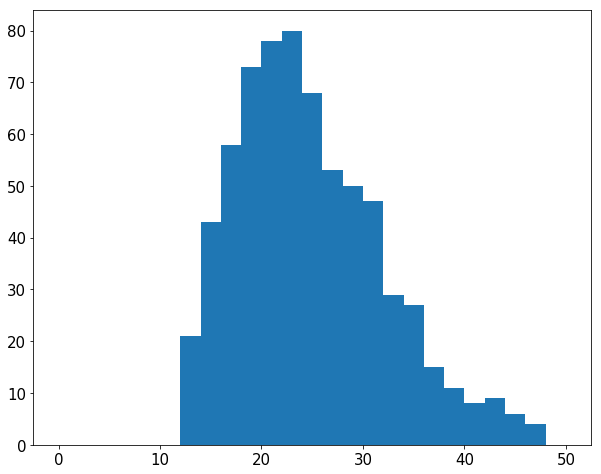

In [93]:
pe = dsts[-2][coref.in_range(dsts[-2].S2e * zcorr(dsts[-2].Z), 115e3, 160e3) & coref.in_range(dsts[-2].Y, -20, 20) & coref.in_range(dsts[-2].X, -150, 150) & (dsts[-2].nS2==2)]
hist(pe.S2w, 25, (0, 50));

8000.0
8000.0
8000.0
8000.0
8000.0


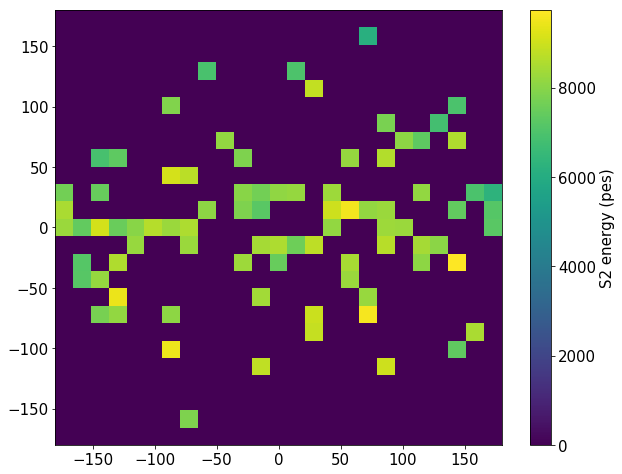

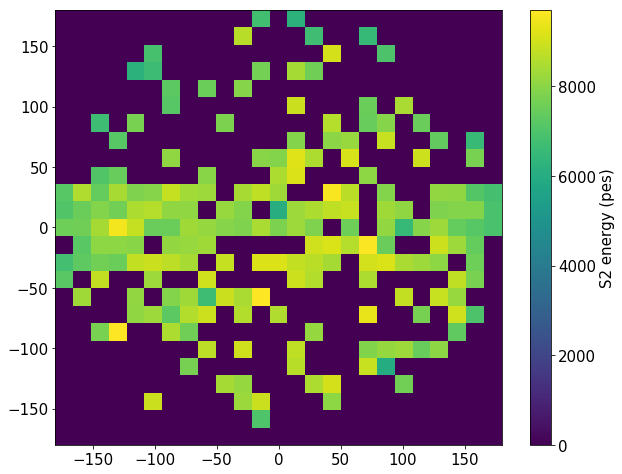

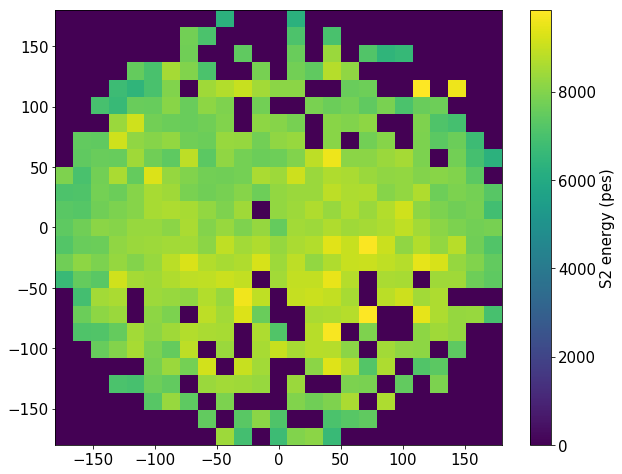

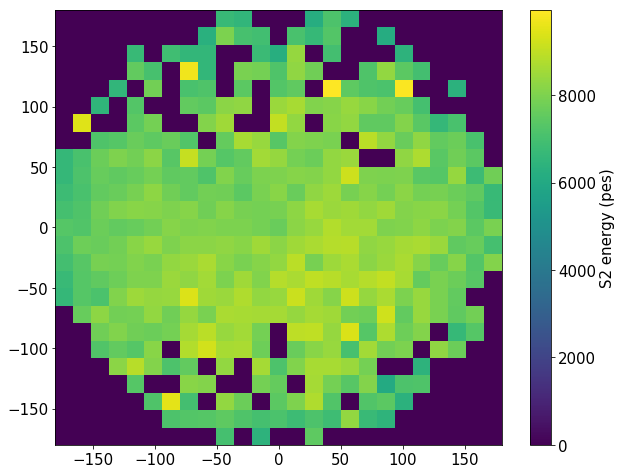

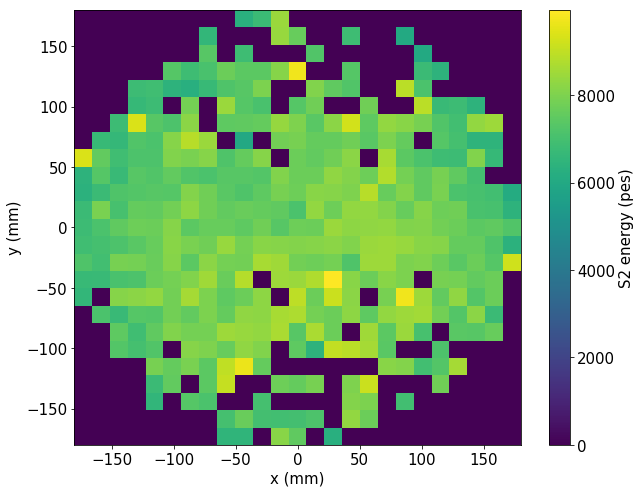

In [11]:
xycorrs = []
for name, dst, zcorr in zip(names, dsts, zcorrs):
    fid = dst[coref.in_range(dst.S2e * zcorr(dst.Z.values), 6e3, 1e4) & coref.in_range(dst.R, 0, 180)]
    pf, _, cb = profile_and_scatter(fid.X, fid.Y, fid.S2e * zcorr(dst.Z), (25, 25), (-180, 180), (-180, 180))
    cb.set_label("S2 energy (pes)")
    xycorrs.append(get_xycorr(*pf[:-1], 8e3))

labels("x (mm)", "y (mm)")

# XYZ corrected spectrum

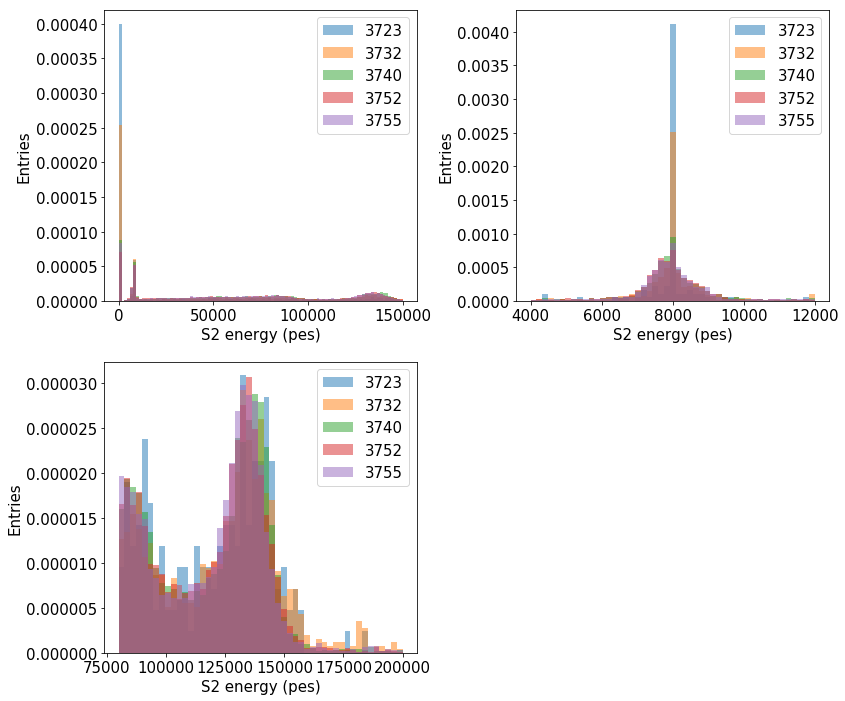

In [12]:
allbins = np.linspace(   0, 15e4, 100)
pebins  = np.linspace(80e3, 20e4,  50)
xrbins  = np.linspace( 4e3, 12e3,  50)

plt.figure().set_size_inches(12, 10)
for name, dst, zcorr, xycorr in zip(names, dsts, zcorrs, xycorrs):
    E = dst.S2e * zcorr(dst.Z.values) * xycorr(dst.X.values, dst.Y.values)
    plt.subplot(2,2,1)
    plt.hist(E, allbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,2)
    plt.hist(E,  xrbins, alpha=0.5, normed=True, label=name)

    plt.subplot(2,2,3)
    plt.hist(E,  pebins, alpha=0.5, normed=True, label=name)

for i in range(1,4):
    plt.subplot(2,2,i)
    labels("S2 energy (pes)", "Entries")
    plt.legend()

plt.tight_layout()

[  2.73750079e+05   7.81023066e+03   4.17128102e+02   5.39050630e+04
   8.77624046e+03   3.29781266e+02   1.36274151e+01] (12.550859032537177, 1.3772994307673876)


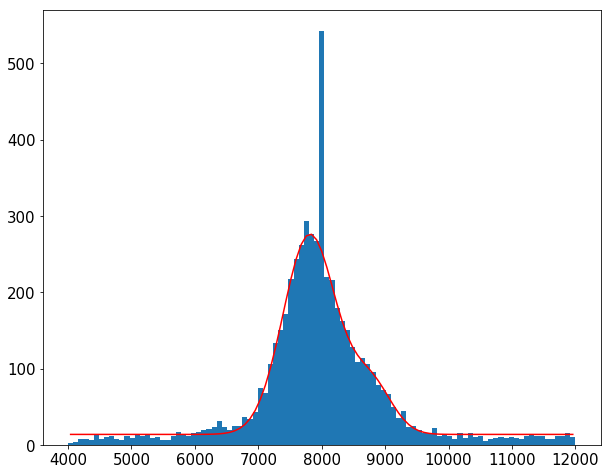

In [17]:
xrbins  = np.linspace( 4e3, 12e3, 100)

E           = np.concatenate([dst.S2e.values * zcorr(dst.Z.values) * xycorr(dst.X.values, dst.Y.values) for name, dst, zcorr, xycorr in zip(names[2:], dsts[2:], zcorrs[2:], xycorrs[2:])])
doublegauss = lambda x, A1, mu1, sig1, A2, mu2, sig2, b: b + fitf.gauss(x, A1, mu1, sig1) + fitf.gauss(x, A2, mu2, sig2)

y, x, _ = hist(E, xrbins)
x = x[:-1] + np.diff(x) * 0.5

sel = y != np.max(y)

low  = 1e3, 7500, 1e2, 1e0, 8500, 1e2,  0
seed = 1e5, 8000, 4e2, 1e3, 9000, 4e2, 10
upp  = 1e8, 8500, 7e2, 1e7, 9900, 9e2, 20
f = fitf.fit(doublegauss, x[sel], y[sel], seed, bounds = (low, upp), fit_range = (5e3, 11e3))
plt.plot(x, f.fn(x), "r-")
print(f.values, reso(f.values[:3], 29.6))

[  2.01297005e+07   1.34893015e+05   7.25916411e+03   8.97071024e+02
  -5.48155770e-03] (12.646344686092059, 5.7661312738177628)


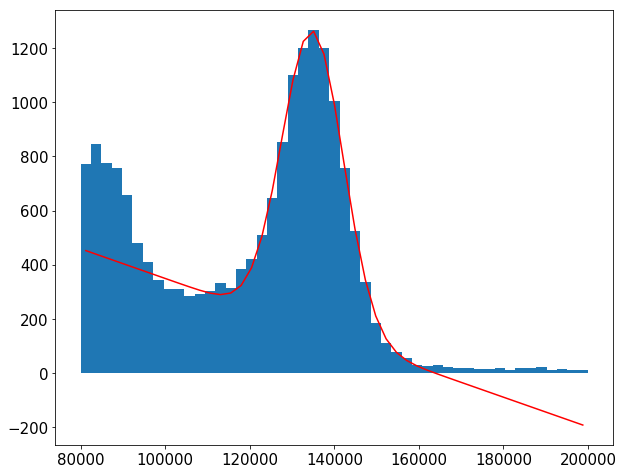

In [18]:
pebins  = np.linspace(80e3, 20e4,  50)

E         = np.concatenate([dst.S2e.values * zcorr(dst.Z.values) * xycorr(dst.X.values, dst.Y.values) for name, dst, zcorr, xycorr in zip(names[2:], dsts[2:], zcorrs[2:], xycorrs[2:])])
expogauss = lambda x, A, mu, sig, a, b: fitf.polynom(x, a, b) + fitf.gauss(x, A, mu, sig)

y, x, _ = hist(E, pebins)
x = x[:-1] + np.diff(x) * 0.5


low  = 1e3, 125e3, 1e3, 1e2, -1e7
seed = 1e5, 130e3, 4e3, 1e3, -1e3
upp  = 1e8, 140e3, 7e4, 1e12,    0
f = fitf.fit(expogauss, x, y, seed, bounds = (low, upp), fit_range = (100e3, 160e3))
plt.plot(x, f.fn(x), "r-")
print(f.values, reso(f.values[:3], 511))

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[  1.04570533e+02   8.00010264e+03   1.18051523e+00   3.96804107e+01
   7.99996594e+03   3.86539993e-01] (0.034677190004402635, 0.0038053868607606654)
[  2.55458442e+02   7.99972770e+03   5.54130285e-01   2.15537046e+01
   7.98807329e+03   3.00630063e+00] (0.01627813117823021, 0.0017863208205598912)
[  5.63756487e+02   8.00045614e+03   1.57015495e+00   1.35147020e+03
   7.99765952e+03   2.65594732e+00] (0.046120672059732679, 0.0050611655512824375)
[  3.02764622e+04   8.78642876e+03   2.03508335e+02   2.46341890e+05
   7.83716947e+03   4.42780228e+02] (5.4429916940556149, 0.59730010053176108)
[  1.50032431e+03   7.99645454e+03   5.00118662e+00   1.56724432e+03
   8.00152546e+03   3.70870192e+00] (0.14697499363512251, 0.016128662950154526)


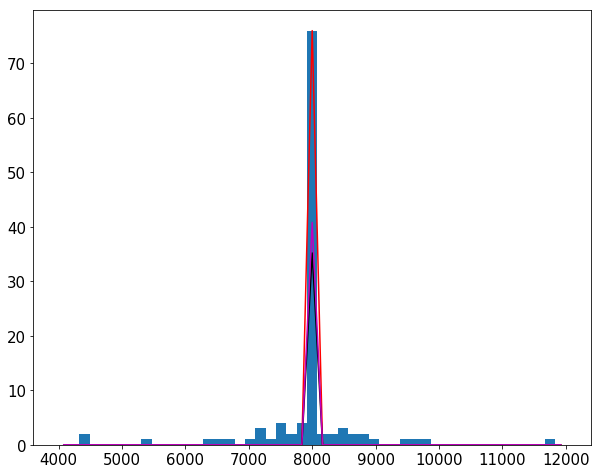

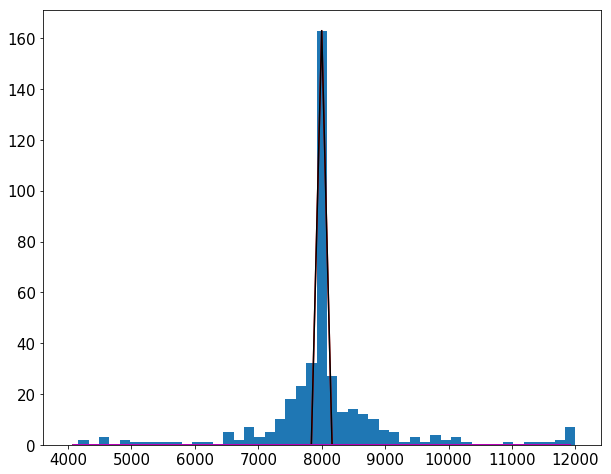

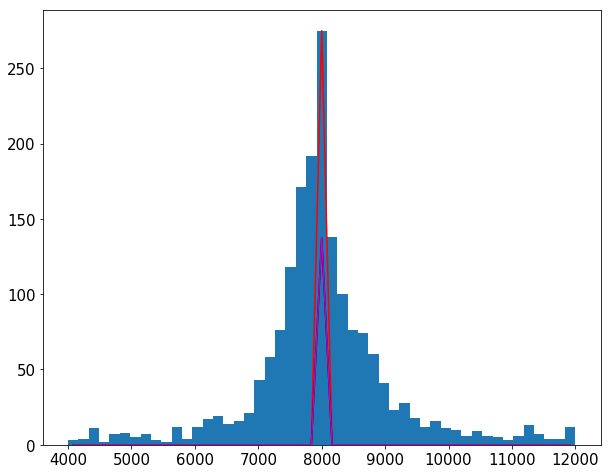

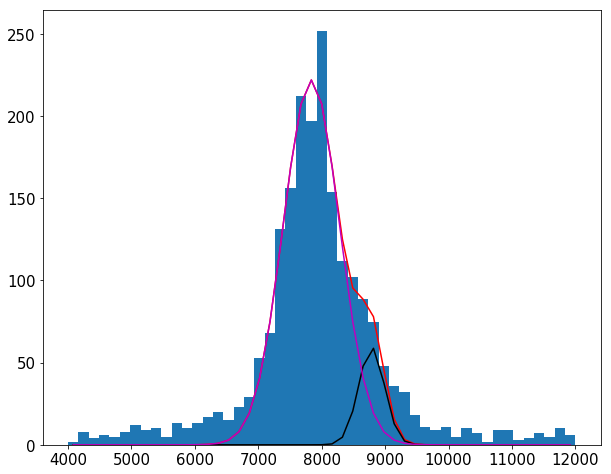

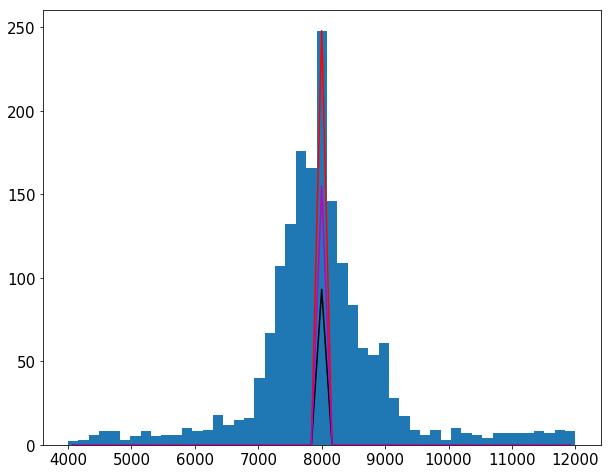

In [15]:
pebins  = np.linspace(80e3, 20e4,  50)
xrbins  = np.linspace( 4e3, 12e3,  50)

doublegauss = lambda x, A1, mu1, sig1, A2, mu2, sig2: fitf.gauss(x, A1, mu1, sig1) + fitf.gauss(x, A2, mu2, sig2)

for name, dst, zcorr, xycorr in zip(names, dsts, zcorrs, xycorrs):
    E = dst.S2e * zcorr(dst.Z.values) * xycorr(dst.X.values, dst.Y.values)
    y, x, _ = hist(E, xrbins)
    x = x[:-1] + np.diff(x) * 0.5
    f = fitf.fit(doublegauss, x, y, (1, 8e3, 4e2, 0.1, 9e3, 4e2), fit_range = (7e3, 9e3))
    plt.plot(x, f.fn(x), "r-")
    plt.plot(x, fitf.gauss(x, *f.values[:3]), "k-")
    plt.plot(x, fitf.gauss(x, *f.values[3:]), "m-")
    print(f.values, reso(f.values[:3], 29.6))
    #break